We are use the popular Flights Dataset to analyze and predict flight delays in airports based on past flight records.
For this dataset, we will only look at the flights in 2014 .
Model used is Logistic Regression

In [ ]:
!pip install pyspark

# Import findspark and findspark.init() to make pyspark importable as a regular library

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName('appName').setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

#importing some packages we need

In [ ]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import pyarrow as pa
from pyarrow import csv
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%matplotlib inline

Removing headers of the dataset and renaming it so that further it will be easier for us analyse

In [ ]:
textFile = sc.textFile('combined_output.csv')
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()
textRDD = textFileRDD.filter(lambda r: r != header)

# Creating the Dataframe from RDD (Resilient Distributed Dataset)

In [ ]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[8])), \
          CRSDepTime=int(r[7]),\
          ArrTime=int(float(r[11])),\
          CRSArrTime=int(r[10]), \
          UniqueCarrier=r[4],\
          DepDelay=int(float(r[9])),\
          Origin=r[5],\
          Dest=r[6], \
          Distance=int(float(r[12])),\
          CarrierDelay=int(float(r[13])),\
          WeatherDelay=int(float(r[14])),\
          NASDelay= int(float(r[15])),\
          SecurityDelay=int(float(r[16])),\
          LateAircraftDelay=int(float(r[17])))
    except:
        x=None
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df = sqlContext.createDataFrame(rowRDD)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DepDelayed is a new column added to dataframe

True for delay > 15 minutes

False for delay <=15 minutes

In [ ]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

In [ ]:
# define hour function to obtain hour of day
def hour_ex(x):
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF
sqlContext.udf.register("hour_ex_py",hour_ex, IntegerType())
f_udf = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f_udf(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
airline_df.head(n=5)

[Row(Year=2014, Month=1, DayofMonth=6, DayOfWeek=1, DepTime=1612, CRSDepTime=1510, ArrTime=1710, CRSArrTime=1620, UniqueCarrier='AA', DepDelay=62, Origin='DFW', Dest='SAT', Distance=247, CarrierDelay=10, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=40, DepDelayed=True, hour=15),
 Row(Year=2014, Month=1, DayofMonth=13, DayOfWeek=1, DepTime=1701, CRSDepTime=1510, ArrTime=1800, CRSArrTime=1620, UniqueCarrier='AA', DepDelay=111, Origin='DFW', Dest='SAT', Distance=247, CarrierDelay=23, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=77, DepDelayed=True, hour=15),
 Row(Year=2014, Month=1, DayofMonth=24, DayOfWeek=5, DepTime=1717, CRSDepTime=1510, ArrTime=1831, CRSArrTime=1620, UniqueCarrier='AA', DepDelay=127, Origin='DFW', Dest='SAT', Distance=247, CarrierDelay=127, WeatherDelay=0, NASDelay=4, SecurityDelay=0, LateAircraftDelay=0, DepDelayed=True, hour=15),
 Row(Year=2014, Month=1, DayofMonth=31, DayOfWeek=5, DepTime=1545, CRSDepTime=1510, ArrTime=1648, CRSA

# Exploration: What are the primary causes for flight delays

In [ ]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF ")

In [ ]:
df_cause_delay = cause_delay.toPandas()
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,2988669,16519549,65350,29483984,21259409


CarrierDelay         30.233686
WeatherDelay          4.250282
NASDelay             23.492979
SecurityDelay         0.092936
LateAircraftDelay    41.930117
dtype: float64


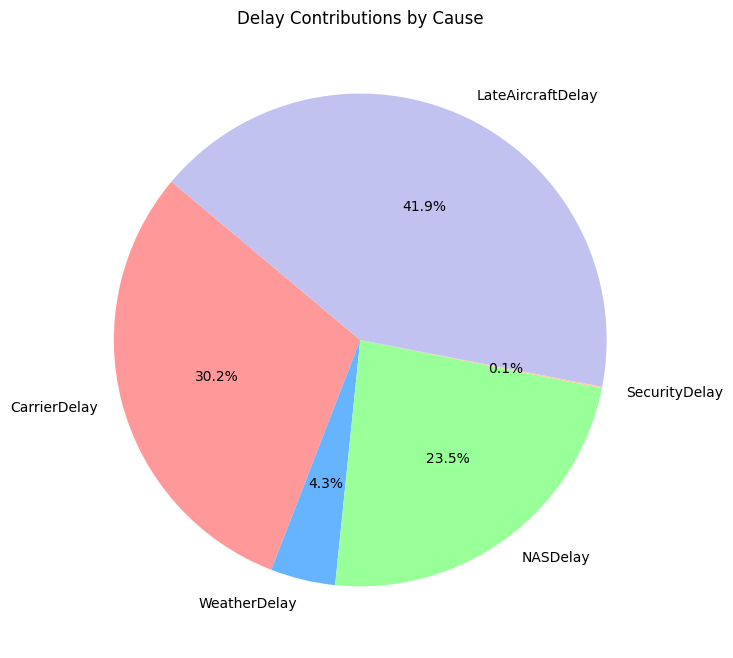

In [ ]:
from pyspark.sql import functions as F

# List of delay columns
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


delay_totals = airline_df.select([F.sum(col).alias(col) for col in delay_columns])

df_delay_totals = delay_totals.toPandas()


total_delays = df_delay_totals.sum()
total_delays_percentage = (total_delays / total_delays.sum()) * 100


print(total_delays_percentage)


plt.figure(figsize=(8, 8))
plt.pie(total_delays_percentage, labels=total_delays_percentage.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Delay Contributions by Cause')
plt.show()


In [ ]:
# Plotting a pie chart to visualize delay contributions by cause
plt.figure(figsize=(8, 8))
plt.pie(total_delays_percentage, labels=total_delays.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Delay Contributions by Cause')
plt.show()


# Exploration : Airport Origin delay per month

In [ ]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [ ]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

Text(0.5, 1.0, 'How much delay does each carrier has in each month?')

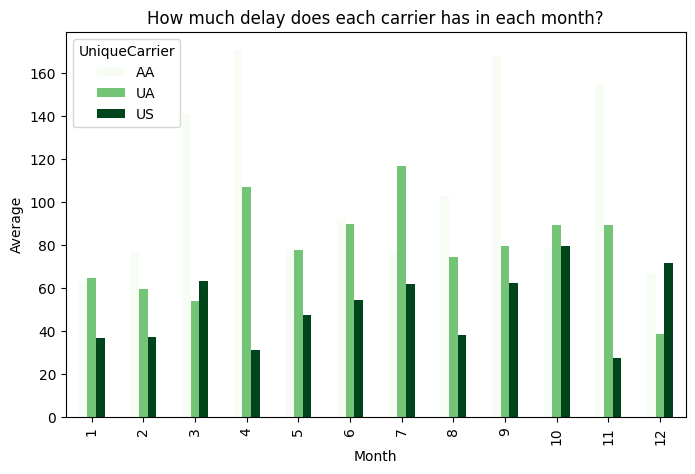

In [ ]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Month')
plt.ylabel('Average')
plt.title('How much delay does each carrier has in each month?')